# Gradient descent in action

## Goal

The goal of this lab is to explore 

## Set up

In [29]:
import numpy as np
import pandas as pd

np.random.seed(999)

from mpl_toolkits.mplot3d import Axes3D # required even though not ref'd!
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

In [30]:
def normalize(X):
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

In [31]:
def plot3d(b0_range, b1_range):
    b0_mesh, b1_mesh = np.meshgrid(b0_range, b1_range, indexing='ij')
    L = np.zeros(b0_mesh.shape)

    for i in range(len(b0_range)):
        for j in range(len(b1_range)):
            L[i,j] = loss([b0_range[i],b1_range[j]], X=X_, y=y)

    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(b0_mesh, b1_mesh, L, alpha=0.7, cmap='coolwarm')
    ax.set_xlabel('$\\beta_0$', fontsize=14)
    ax.set_ylabel('$\\beta_1$', fontsize=14)

## Simple function gradient descent

In [32]:
def fplot(f,xrange,fstr='',x0=None,xn=None):
    plt.figure(figsize=(3.5,2))
    lx = np.linspace(*xrange,200)    
    fx = [f(x) for x in lx]
    plt.plot(lx, fx, lw=.75)
    if x0 is not None:
        plt.scatter([x0], [f(x0)], c='orange')
        plt.scatter([xn], [f(xn)], c='green')
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel(fstr, fontsize=12)

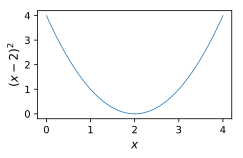

In [33]:
def f(x) : return (x-2)**2
fplot(f, xrange=(0,4), fstr="$(x-2)^2$")

In [34]:
def df(x): return 2*(x-2)

In [35]:
x = .8 # initial x location

In [36]:
x = x - .4 * df(x); print(x)

1.76


In [37]:
for i in range(5):
    x = x - .4 * df(x); print(x)

1.952
1.9904
1.99808
1.999616
1.9999232


Minimize $x \sin(0.6x)$

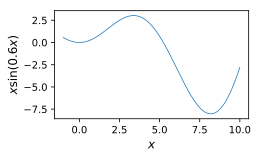

In [38]:
def f(x) : return np.sin(0.6*x)*x
fplot(f, xrange=(-1,10), fstr="$x \sin(0.6x)$")

In [39]:
def df(x): return 0.6*x * np.cos(0.6*x) + np.sin(0.6*x)
x0 = np.random.rand()*11 - 1 # pick value between -1 and 10
x0

7.8377084408765665

In [40]:
x = x0
for i in range(10):
    x = x - .5 * df(x); print(f"{x:.10f}")

8.3606422605
8.0869245252
8.2440692582
8.1568434479
8.2063827307
8.1785686801
8.1942930504
8.1854367232
8.1904355858
8.1876174222


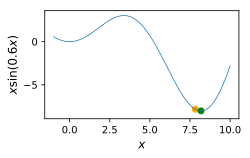

In [41]:
fplot(f, xrange=(-1,10), fstr="$x \sin(0.6x)$", x0=x0, xn=x)

## Examine loss surface for LSTAT var from Boston dataset

In [42]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [43]:
lm = LinearRegression()
lm.fit(X, y)
print(f"Coefficients: {np.array([lm.intercept_]+list(lm.coef_))}")

Coefficients: [ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]


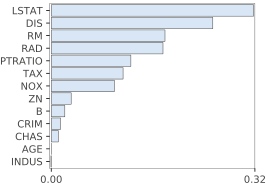

In [44]:
from rfpimp import *

I = importances(lm, X, y)
plot_importances(I)

In [45]:
X_ = X['LSTAT'].values.reshape(-1,1)

lm = LinearRegression()
lm.fit(X_, y)
print(f"True OLS coefficients: {np.array([lm.intercept_]+list(lm.coef_))}")

True OLS coefficients: [34.55384088 -0.95004935]


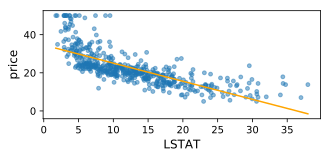

In [46]:
fig, ax1 = plt.subplots(figsize=(5,2.0))
ax1.scatter(X_, y, s=15, alpha=.5)
lx = np.linspace(np.min(X_), np.max(X_), num=len(X))
ax1.plot(lx, lm.predict(lx.reshape(-1,1)), c='orange')
ax1.set_xlabel("LSTAT", fontsize=12)
ax1.set_ylabel("price", fontsize=12)
plt.show()

In [47]:
def loss(B,X,y):
    y_pred = B[0] + X*B[1]
    return np.mean((y - y_pred)**2)

In [48]:
loss(np.array([1,1]), X_, y) # demo loss function at beta0=beta1=1.0

214.16337272805382

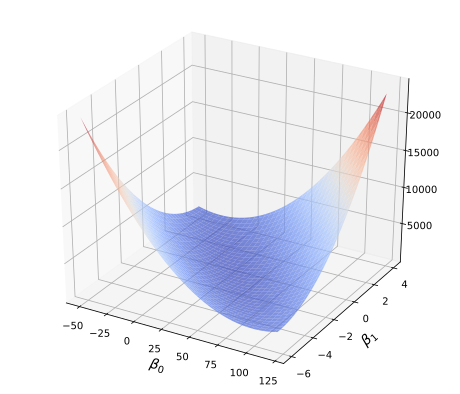

In [49]:
b0_range = np.linspace(-50, 120, 70)
b1_range = np.linspace(-6, 4, 70)

plot3d(b0_range, b1_range)

In [50]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

In [51]:
X_norm = normalize(X)

In [52]:
X_ = X_norm['LSTAT'].values.reshape(-1,1)

lm = LinearRegression()
lm.fit(X_, y)
print(f"True OLS coefficients: {np.array([lm.intercept_]+list(lm.coef_))}")

True OLS coefficients: [22.53280632 -6.77765364]


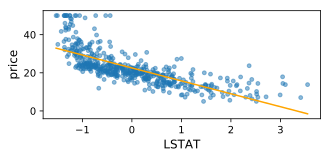

In [53]:
fig, ax1 = plt.subplots(figsize=(5,2.0))
ax1.scatter(X_, y, s=15, alpha=.5)
lx = np.linspace(np.min(X_), np.max(X_), num=len(X))
ax1.plot(lx, lm.predict(lx.reshape(-1,1)), c='orange')
ax1.set_xlabel("LSTAT", fontsize=12)
ax1.set_ylabel("price", fontsize=12)
plt.show()

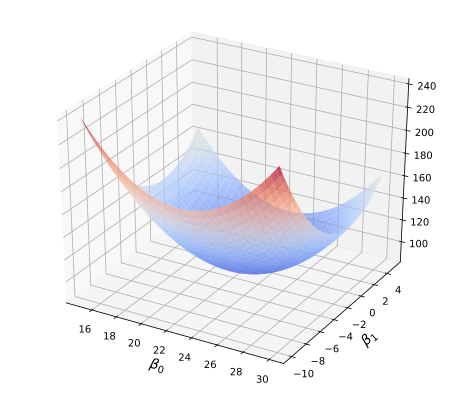

In [54]:
b0_range = np.linspace(15, 30, 70)
b1_range = np.linspace(-10, 5, 70)

plot3d(b0_range, b1_range)